# Name: Abhay Sharma
# Roll: 22CH10001

In [1]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import time

Experiment 1

In [2]:
device = torch.device('cpu')
torch.manual_seed(2022)
torch.cuda.manual_seed_all(2022)
np.random.seed(2022)
random.seed(2022)

Experiment 2

In [2]:
dataset_path = 'data'

class FaceAgeDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        self.image_paths = []
        self.ages = []
        for folder in os.listdir(data_path):
            folder_path = os.path.join(data_path, folder)
            if os.path.isdir(folder_path):
                age = int(folder)
                for file in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file)
                    self.image_paths.append(file_path)
                    self.ages.append(age)
        
        data = list(zip(self.image_paths, self.ages))
        random.shuffle(data)
        self.image_paths, self.ages = zip(*data)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        age = self.ages[idx]
        
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, age

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


dataset = FaceAgeDataset(dataset_path, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_test_dataset = train_test_split(dataset, train_size=train_size)
val_dataset, test_dataset = train_test_split(val_test_dataset, train_size=val_size)

batch_size = 128  # Adjust this to a consistent value for both loaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Overall dataset size: {len(dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Overall dataset size: 9790
Training dataset size: 6853
Validation dataset size: 1468
Testing dataset size: 1469


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(images[i].numpy().transpose((1, 2, 0)), cmap='gray')
    axs[i].set_title('Label: ' + str(labels[i].item()))
    axs[i].axis('off')
plt.show()

In [8]:
len(age.unique())

65

Experiment 3

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, padding='same')
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 5, padding='same')
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, 5, padding='same')
        self.bn3 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 4 * 4, 128)

        self.fc2 = nn.Linear(128, 64)

        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.bn1(self.relu(self.conv1(x))))
        x = self.pool(self.bn2(self.relu(self.conv2(x))))
        x = self.pool(self.bn3(self.relu(self.conv3(x))))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


net = Net().to(device)

In [22]:
from torchsummary import summary

summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 32, 32]             560
              ReLU-2           [-1, 20, 32, 32]               0
         MaxPool2d-3           [-1, 20, 16, 16]               0
            Conv2d-4           [-1, 50, 16, 16]           9,050
              ReLU-5           [-1, 50, 16, 16]               0
         MaxPool2d-6             [-1, 50, 8, 8]               0
            Linear-7                  [-1, 512]       1,638,912
              ReLU-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
             ReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
Total params: 1,812,746
Trainable param

Experiment 4

In [72]:
criterion = nn.MSELoss()  # Define loss function

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # Define optimizer

num_epochs = 25  # Set number of epochs

train_loss_history=[]
test_loss_history=[]

start_time = time.time()

for epoch in range(num_epochs):
    running_train_loss = 0.0
    for images, labels in train_loader:
      # Forward pass
      outputs = net(images)

      # Calculate loss
      loss = criterion(outputs, labels.unsqueeze(1).float())  # Convert labels to float for loss calculation

      # Backpropagation and update weights
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # print statistics
      running_train_loss += loss.item()
    
      running_valid_loss=0
    for images, labels in val_loader:
      with torch.no_grad():
        outputs = net(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        running_valid_loss+= loss.item()

    # Print training progress (optional)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    print(f'[{epoch + 1}] training_loss: {running_train_loss / len(train_loader):.3f} validation_loss: {running_valid_loss / len(val_loader):.3f}')

    train_loss_history.append(running_train_loss/len(train_loader))
    test_loss_history.append(running_valid_loss/len(val_loader))

print('Finished Training')
end_time = time.time()
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))

c:\Users\91824\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\91824\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([60, 1])) that is different to the input size (torch.Size([60, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\91824\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([58, 1])) that is different to the input size (torch.Size([58, 128])). This will lik

[1] training_loss: 33.688 validation_loss: 158.541
[2] training_loss: 29.855 validation_loss: 154.745
[3] training_loss: 31.111 validation_loss: 155.167
[4] training_loss: 29.069 validation_loss: 156.503
[5] training_loss: 29.664 validation_loss: 155.754
[6] training_loss: 29.015 validation_loss: 151.944
[7] training_loss: 28.827 validation_loss: 162.733
[8] training_loss: 32.766 validation_loss: 157.904
[9] training_loss: 31.616 validation_loss: 167.152
[10] training_loss: 29.888 validation_loss: 158.716
[11] training_loss: 29.591 validation_loss: 166.343
[12] training_loss: 30.917 validation_loss: 162.115
[13] training_loss: 28.189 validation_loss: 155.769
[14] training_loss: 28.860 validation_loss: 159.682
[15] training_loss: 30.573 validation_loss: 158.764
[16] training_loss: 28.341 validation_loss: 154.259
[17] training_loss: 27.641 validation_loss: 151.621
[18] training_loss: 27.080 validation_loss: 154.745
[19] training_loss: 27.428 validation_loss: 159.006
[20] training_loss: 2

Experiment 5

In [40]:
torch.save(net.state_dict(), './cnn.pth')

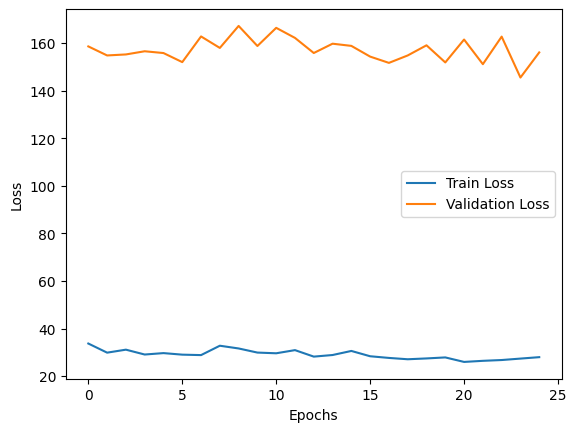

In [73]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test MSE Loss: 137.7051
(1468,)


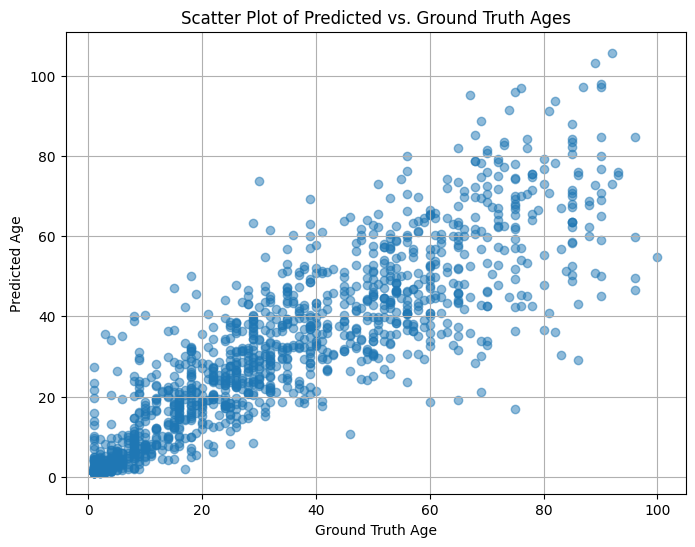

In [70]:
import torch
import matplotlib.pyplot as plt

model = Net()
model.load_state_dict(torch.load('cnn.pth'))
model.eval()

device = torch.device('cpu')

test_loss = 0.0
predicted_ages = []
ground_truth_ages = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        test_loss += loss.item() * inputs.size(0)

        predicted_ages.extend(outputs.cpu().numpy())
        ground_truth_ages.extend(labels.cpu().numpy())

# Ensure that ground_truth_ages and predicted_ages have the same length
if len(ground_truth_ages) != len(predicted_ages):
    raise ValueError("ground_truth_ages and predicted_ages must have the same length")


test_loss /= len(test_loader.dataset)
print(f'Test MSE Loss: {test_loss:.4f}')

predicted_ages = np.array(predicted_ages)
print(predicted_ages[:, 0].shape)

plt.figure(figsize=(8, 6))
plt.scatter(x=ground_truth_ages, y=predicted_ages[:,0], alpha=0.5)
plt.xlabel('Ground Truth Age')
plt.ylabel('Predicted Age')
plt.title('Scatter Plot of Predicted vs. Ground Truth Ages')
plt.grid(True)
plt.show()

In [43]:
import torch

# Load the saved model
model = Net()
model.load_state_dict(torch.load("cnn.pth"))
model.eval()

test_loss = 0.0
predicted_ages = []
ground_truth_ages = []

# Assuming you have a DataLoader for your test data called test_loader
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels.float())
    test_loss += loss.item() * inputs.size(0)
    
    # Get the predicted ages
    _, predicted = torch.max(outputs.data, 1)
    
    print("Predicted ages: ", predicted)
    
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))



Predicted ages:  tensor([127, 127,  26,  69,  10,  47,  90, 114,  26,  23,  96,   5,  47,  90,
         69,  86,  95,  80,  47,  58,  58,  65,  76,  65,  79,  95,  38,  87,
         95,  95,  95,  87,  26,  80,  95,  76,  58,  47,  17,  47, 127,  87,
        118,  95,  80,  79,  87, 127,  26,  26,  95,  76,  47,  24,  17,  87,
         95,  26,  87, 101, 118,  95,  58,  26, 127,  95,  26,  47,  65,  47,
         47,  47,  87,  80,  95,  95,  69,  96,  58,  87, 107,  58,  26,  95,
         80, 127,  95,  95,  23,  47,  65, 118,  17,  65,  87,  26,  87,  80,
         95,  86, 127,  47,  58, 108,  95,  69, 127,  95,  80,  95,  95, 108,
         87,  87,  80,  10,  65,  95,  65, 115,  69,  68,  95,  95, 127,  95,
         58,  47])
Predicted ages:  tensor([ 80,  58,  26, 118,  24,  65,  46,  65,  65,  47,  58,  47,  95,  95,
         80,  13,  58,  47,  80,  80,  87, 108,  47,  80,  17,  95,  47,  58,
         65, 127,  47,  87,  26,  58,  47,  87,  80,  65,  47,  65,  26,  47,
         95

In [44]:
# Calculate the MSE error
mse_error = criterion(predicted.float(), labels.float())
print('MSE Error: ', mse_error.item())

MSE Error:  2721.7333984375
